In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import arviz as az
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Import our package
import bayes_ordinal as bo
from bayes_ordinal.config import get_production_config, get_quick_test_config

# Configure plotting
plt.style.use('default')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Load Wine Quality Dataset
wine_data = pd.read_csv("/Users/adithyan/Documents/MScProject_copy/bayes_ordinal/Dataset/wine+quality/winequality-red.csv", sep=';')

print(f"Dataset shape: {wine_data.shape}")
print(f"Quality distribution:\n{wine_data['quality'].value_counts().sort_index()}")

# Analyze the original data structure
y_original = wine_data['quality'].values
print(f"\nOriginal quality values: {np.unique(y_original)}")
print(f"Original quality distribution: {np.bincount(y_original - np.min(y_original))}")
print(f"Original quality proportions: {np.bincount(y_original - np.min(y_original)) / len(y_original)}")

Dataset shape: (1599, 12)
Quality distribution:
quality
3     10
4     53
5    681
6    638
7    199
8     18
Name: count, dtype: int64

Original quality values: [3 4 5 6 7 8]
Original quality distribution: [ 10  53 681 638 199  18]
Original quality proportions: [0.00625391 0.03314572 0.42589118 0.39899937 0.12445278 0.01125704]


In [3]:
# 1. Keep original scale for better interpretability
y = y_original.copy()
X_raw = wine_data.drop('quality', axis=1).values
feature_names = wine_data.drop('quality', axis=1).columns.tolist()

print(f"Using original quality scale: {np.min(y)} to {np.max(y)}")
print(f"Quality categories: {np.unique(y)}")
print(f"Number of categories (K): {len(np.unique(y))}")

# 2. Convert to 0-indexed for the package (but keep track of original scale)
y_0_indexed = y - np.min(y)
K = len(np.unique(y_0_indexed))

print(f"0-indexed quality values: {np.unique(y_0_indexed)}")
print(f"0-indexed distribution: {np.bincount(y_0_indexed)}")

# 3. Validate and preprocess data
y_valid, X_valid, K_valid = bo.validate_ordinal_data(y_0_indexed, X_raw, K)

# 4. Use robust standardization (not standard scaling for ordinal data)
# For ordinal regression, we want to preserve the relative relationships
X_centered = X_valid - X_valid.mean(axis=0)
X_scaled = X_centered / X_valid.std(axis=0)

print(f"✓ Data validation passed: K={K_valid}")
print(f"✓ Features centered and scaled")

# 5. Compute category proportions
category_props = bo.compute_category_proportions(y_valid, K)
print(f"✓ Category proportions:")
for i, prop in enumerate(category_props):
    original_quality = i + np.min(y)
    print(f"  Quality {original_quality}: {prop:.3f}")

# 6. Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_valid, test_size=0.2, random_state=42, stratify=y_valid
)

print(f"\nTrain/Test split:")
print(f"  Training: {X_train.shape[0]} samples")
print(f"  Testing: {X_test.shape[0]} samples")

print("✓ Data preprocessing complete!")

Using original quality scale: 3 to 8
Quality categories: [3 4 5 6 7 8]
Number of categories (K): 6
0-indexed quality values: [0 1 2 3 4 5]
0-indexed distribution: [ 10  53 681 638 199  18]
✓ Data validation passed: K=6
✓ Features centered and scaled
✓ Category proportions:
  Quality 3: 0.006
  Quality 4: 0.033
  Quality 5: 0.426
  Quality 6: 0.399
  Quality 7: 0.124
  Quality 8: 0.011

Train/Test split:
  Training: 1279 samples
  Testing: 320 samples
✓ Data preprocessing complete!


In [4]:
# Analyze the observed distribution to inform priors
observed_dist = np.bincount(y_train, minlength=K)
observed_props = observed_dist / observed_dist.sum()

print("Observed training data distribution:")
for i, prop in enumerate(observed_props):
    original_quality = i + np.min(y)
    print(f"  Quality {original_quality}: {prop:.3f}")

# Create data-informed priors based on the observed distribution
# Use the observed proportions to set reasonable cutpoint priors
cumulative_props = np.cumsum(observed_props[:-1])  # Exclude last category
cutpoint_means = np.log(cumulative_props / (1 - cumulative_props))  # Logit transform

print(f"\nCumulative proportions: {cumulative_props}")
print(f"Logit-transformed cutpoint means: {cutpoint_means}")

# Create informed priors
informed_priors = {
    'cut_mu': cutpoint_means,  # Data-informed cutpoint means
    'cut_sigma': np.full(K-1, 0.5),  # Tight priors for cutpoints
    'coef_mu': 0.0,
    'coef_sigma': 0.3,  # Much tighter priors for coefficients
    'u_sigma': 1.0,
    'gamma_mu': 0.0,
    'gamma_sigma': 0.5  # Tighter priors for partial odds
}

print(f"\nInformed priors:")
print(f"  cut_mu: {informed_priors['cut_mu']}")
print(f"  cut_sigma: {informed_priors['cut_sigma']}")
print(f"  coef_sigma: {informed_priors['coef_sigma']}")

Observed training data distribution:
  Quality 3: 0.006
  Quality 4: 0.033
  Quality 5: 0.426
  Quality 6: 0.399
  Quality 7: 0.124
  Quality 8: 0.012

Cumulative proportions: [0.00625489 0.03909304 0.46520719 0.86395622 0.98827209]
Logit-transformed cutpoint means: [-5.06811773 -3.2019331  -0.13939651  1.84854531  4.43398637]

Informed priors:
  cut_mu: [-5.06811773 -3.2019331  -0.13939651  1.84854531  4.43398637]
  cut_sigma: [0.5 0.5 0.5 0.5 0.5]
  coef_sigma: 0.3


In [5]:
# Build models with informed priors
models = {
    'cumulative_logit': bo.cumulative_model(
        y_train, X_train, K, informed_priors, link="logit"
    ),
    'cumulative_probit': bo.cumulative_model(
        y_train, X_train, K, informed_priors, link="probit"
    ),
    'partial_odds': bo.partial_odds_model(
        y_train, X_train, K, informed_priors
    )
}

print("✓ Models built with informed priors")

✓ Models built with informed priors


In [6]:
prior_results = {}
for model_name, model in models.items():
    print(f"\nRunning prior predictive check for {model_name}...")
    
    try:
        prior_idata = bo.run_prior_predictive(model, draws=200, plot=False)
        prior_results[model_name] = prior_idata
        
        # Validate the simulated data
        sim_quality = prior_idata.prior_predictive['y_obs'].values.flatten()
        sim_dist = np.bincount(sim_quality.astype(int), minlength=K)
        sim_props = sim_dist / sim_dist.sum()
        
        print(f"  ✓ Prior predictive samples: {len(sim_quality)}")
        print(f"  ✓ Quality range: {sim_quality.min()}-{sim_quality.max()}")
        print(f"  ✓ Mean quality: {sim_quality.mean():.2f}")
        
        # Compare with observed data
        mean_diff = abs(sim_quality.mean() - y_train.mean())
        print(f"  ✓ Mean difference from observed: {mean_diff:.2f}")
        
        if mean_diff < 0.5:
            print(f"  ✓ Prior predictive is reasonable")
        else:
            print(f"  ⚠ Prior predictive differs significantly from observed")
            
    except Exception as e:
        print(f"  ✗ Error in prior predictive check: {e}")
        prior_results[model_name] = None


Running prior predictive check for cumulative_logit...


Sampling: [alpha, beta, y_obs]
Sampling: [alpha, beta, y_obs]


  ✓ Prior predictive samples: 255800
  ✓ Quality range: 0-5
  ✓ Mean quality: 2.64
  ✓ Mean difference from observed: 0.00
  ✓ Prior predictive is reasonable

Running prior predictive check for cumulative_probit...


Sampling: [beta, gamma, y_obs]


  ✓ Prior predictive samples: 255800
  ✓ Quality range: 0-5
  ✓ Mean quality: 2.61
  ✓ Mean difference from observed: 0.02
  ✓ Prior predictive is reasonable

Running prior predictive check for partial_odds...
  ✓ Prior predictive samples: 255800
  ✓ Quality range: 0-5
  ✓ Mean quality: 2.30
  ✓ Mean difference from observed: 0.34
  ✓ Prior predictive is reasonable


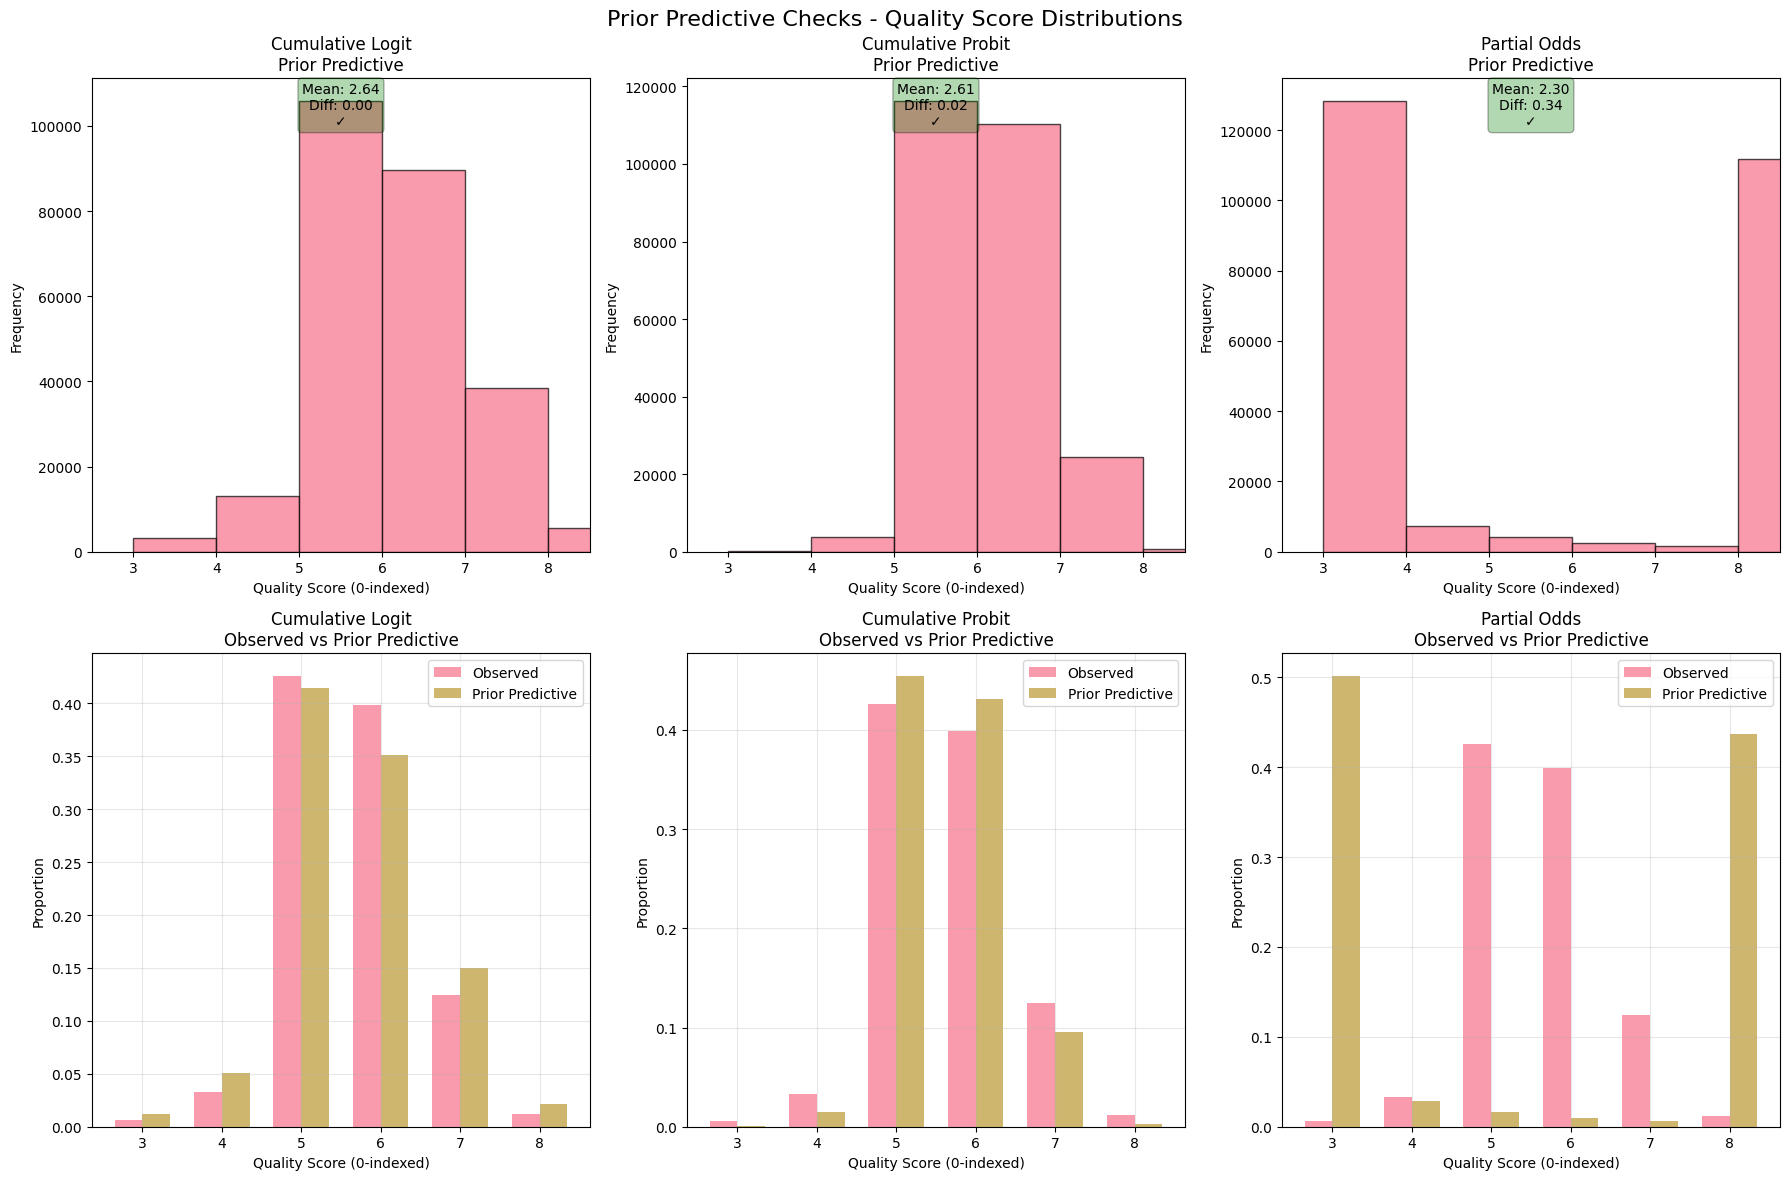

✓ Prior predictive visualization completed!


In [7]:
# Create corrected visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Prior Predictive Checks - Quality Score Distributions', fontsize=16)

# Row 1: Prior predictive distributions
for i, (model_name, prior_idata) in enumerate(prior_results.items()):
    if prior_idata is not None and 'y_obs' in prior_idata.prior_predictive:
        sim_quality = prior_idata.prior_predictive['y_obs'].values.flatten()
        
        # Use correct bins for 0-indexed data
        axes[0, i].hist(sim_quality, bins=range(0, K+1), alpha=0.7, edgecolor='black')
        axes[0, i].set_title(f'{model_name.replace("_", " ").title()}\nPrior Predictive')
        axes[0, i].set_xlabel('Quality Score (0-indexed)')
        axes[0, i].set_ylabel('Frequency')
        axes[0, i].set_xlim(-0.5, K-0.5)
        
        # Add original quality labels
        original_labels = [f"{j + np.min(y)}" for j in range(K)]
        axes[0, i].set_xticks(range(K))
        axes[0, i].set_xticklabels(original_labels)
        
        # Add validation info
        mean_val = sim_quality.mean()
        mean_diff = abs(mean_val - y_train.mean())
        status = "✓" if mean_diff < 0.5 else "⚠"
        color = "green" if mean_diff < 0.5 else "orange"
        axes[0, i].text(0.5, 0.9, f'Mean: {mean_val:.2f}\nDiff: {mean_diff:.2f}\n{status}', 
                       transform=axes[0, i].transAxes, ha='center',
                       bbox=dict(boxstyle="round,pad=0.3", facecolor=color, alpha=0.3))
    else:
        axes[0, i].text(0.5, 0.5, 'No data', ha='center', va='center', 
                       transform=axes[0, i].transAxes)
        axes[0, i].set_title(f'{model_name.replace("_", " ").title()}')

# Row 2: Comparison with observed data
observed_dist = np.bincount(y_train, minlength=K)
for i, (model_name, prior_idata) in enumerate(prior_results.items()):
    if prior_idata is not None and 'y_obs' in prior_idata.prior_predictive:
        sim_quality = prior_idata.prior_predictive['y_obs'].values.flatten()
        sim_dist = np.bincount(sim_quality.astype(int), minlength=K)
        
        # Normalize for comparison
        sim_dist_norm = sim_dist / sim_dist.sum()
        observed_dist_norm = observed_dist / observed_dist.sum()
        
        x = np.arange(K)
        width = 0.35
        
        axes[1, i].bar(x - width/2, observed_dist_norm, width, label='Observed', alpha=0.7)
        axes[1, i].bar(x + width/2, sim_dist_norm, width, label='Prior Predictive', alpha=0.7)
        axes[1, i].set_title(f'{model_name.replace("_", " ").title()}\nObserved vs Prior Predictive')
        axes[1, i].set_xlabel('Quality Score (0-indexed)')
        axes[1, i].set_ylabel('Proportion')
        axes[1, i].set_xticks(x)
        axes[1, i].set_xticklabels([f"{j + np.min(y)}" for j in range(K)])
        axes[1, i].legend()
        axes[1, i].grid(True, alpha=0.3)
    else:
        axes[1, i].text(0.5, 0.5, 'No data', ha='center', va='center', 
                       transform=axes[1, i].transAxes)
        axes[1, i].set_title(f'{model_name.replace("_", " ").title()}')

plt.tight_layout()
plt.show()

print("✓ Prior predictive visualization completed!")

In [8]:
# Use proper sampling parameters for convergence
fit_results = {}
for model_name, model in models.items():
    print(f"\nFitting {model_name}...")
    
    try:
        idata = bo.fit_model(
            model,
            draws=1000,  # More draws for better convergence
            tune=500,
            chains=4,    # More chains for better diagnostics
            smoke_test=False,
            return_inferencedata=True
        )
        
        # Validate the fitted model
        conv_check = bo.check_convergence(idata)
        
        print(f"  ✓ Model fitted successfully")
        print(f"  ✓ Converged: {conv_check['converged']}")
        print(f"  ✓ Divergences: {conv_check['n_divergences']}")
        print(f"  ✓ Bad R-hat: {conv_check['n_bad_rhat']}")
        print(f"  ✓ Bad ESS: {conv_check['n_bad_ess']}")
        
        # Warnings for convergence issues
        if not conv_check['converged']:
            print(f"  ⚠ WARNING: {model_name} has convergence issues!")
        if conv_check['n_divergences'] > 0:
            print(f"  ⚠ WARNING: {conv_check['n_divergences']} divergences detected!")
        if conv_check['n_bad_rhat'] > 0:
            print(f"  ⚠ WARNING: {conv_check['n_bad_rhat']} parameters have poor R-hat!")
        
        fit_results[model_name] = idata
        
    except Exception as e:
        print(f"  ✗ {model_name} failed: {e}")
        fit_results[model_name] = None

print(f"\n✓ Model fitting completed!")
print(f"Successfully fitted: {len([r for r in fit_results.values() if r is not None])}/{len(models)} models")

Initializing NUTS using jitter+adapt_diag...



Fitting cumulative_logit...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 8 seconds.


  ✓ Model fitted successfully
  ✓ Converged: True
  ✓ Divergences: 0
  ✓ Bad R-hat: 0
  ✓ Bad ESS: 0

Fitting cumulative_probit...


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 40 seconds.
Initializing NUTS using jitter+adapt_diag...


  ✓ Model fitted successfully
  ✓ Converged: True
  ✓ Divergences: 0
  ✓ Bad R-hat: 0
  ✓ Bad ESS: 0

Fitting partial_odds...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [gamma, beta]


Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 5 seconds.


  ✓ Model fitted successfully
  ✓ Converged: True
  ✓ Divergences: 0
  ✓ Bad R-hat: 0
  ✓ Bad ESS: 0

✓ Model fitting completed!
Successfully fitted: 3/3 models


In [9]:
# Check convergence for fitted models
print("\nConvergence Diagnostics:")
convergence_summary = {}

for model_name, idata in fit_results.items():
    if idata is not None:
        conv_check = bo.check_convergence(idata)
        convergence_summary[model_name] = conv_check
        
        print(f"\n{model_name}:")
        print(f"  Converged: {conv_check['converged']}")
        print(f"  Divergences: {conv_check['n_divergences']}")
        print(f"  Bad R-hat: {conv_check['n_bad_rhat']}")
        print(f"  Bad ESS: {conv_check['n_bad_ess']}")

# Model comparison
print("\nModel Comparison:")
comparison = None
if len([r for r in fit_results.values() if r is not None]) > 1:
    try:
        comparison = bo.compare_models(
            {name: models[name] for name, idata in fit_results.items() if idata is not None},
            {name: idata for name, idata in fit_results.items() if idata is not None},
            ic="loo"
        )
        print("\nModel comparison results:")
        print(comparison)
        
        # Get best model
        best_model = comparison.index[0]
        print(f"\nBest model: {best_model}")
        
    except Exception as e:
        print(f"✗ Model comparison failed: {e}")
        comparison = None
else:
    print("Need at least 2 fitted models for comparison")


Convergence Diagnostics:

cumulative_logit:
  Converged: True
  Divergences: 0
  Bad R-hat: 0
  Bad ESS: 0

cumulative_probit:
  Converged: True
  Divergences: 0
  Bad R-hat: 0
  Bad ESS: 0

partial_odds:
  Converged: True
  Divergences: 0
  Bad R-hat: 0
  Bad ESS: 0

Model Comparison:

Model comparison results:
                   rank     elpd_loo      p_loo  elpd_diff    weight  \
cumulative_logit      0  2504.846194  15.391357   0.000000  0.819312   
cumulative_probit     1  2521.689608  20.077243  16.843414  0.079935   
partial_odds          2  2530.183194  13.792656  25.337000  0.100753   

                          se        dse  warning     scale  n_bad_k  
cumulative_logit   57.000620   0.000000    False  deviance        0  
cumulative_probit  62.345872   9.366132    False  deviance        0  
partial_odds       48.981400  10.593587    False  deviance        0  

Best model: cumulative_logit


Best model from comparison: cumulative_logit

Creating visualizations for cumulative_logit...
Creating coefficient effects plot...


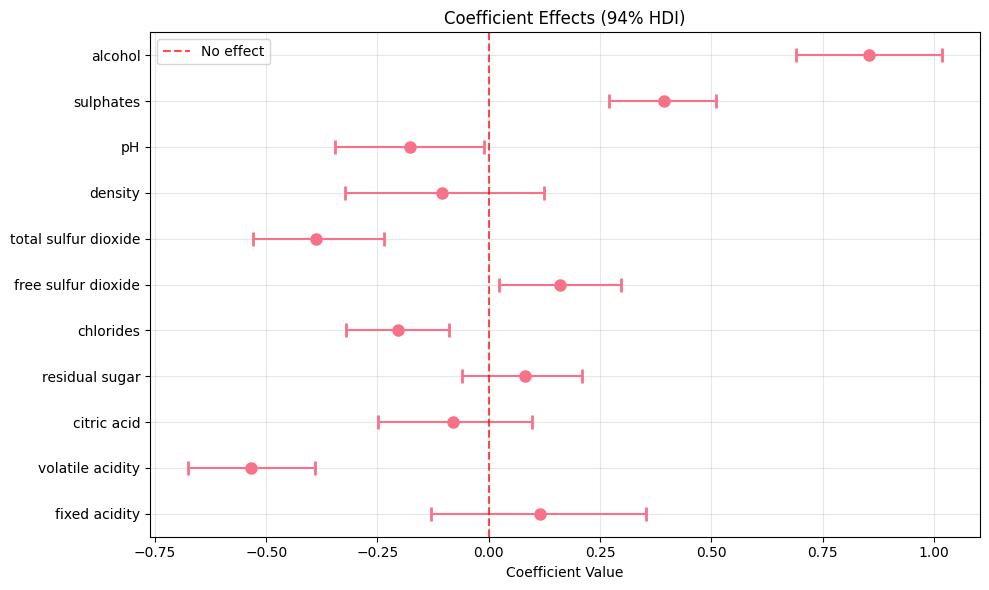

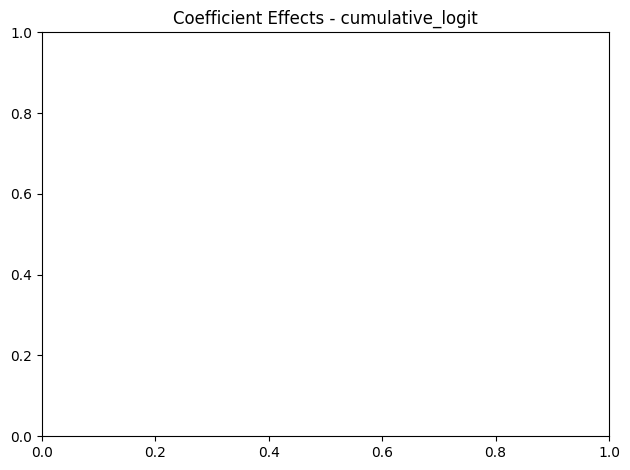

✓ Coefficient plot displayed successfully
Creating cutpoint estimates plot...


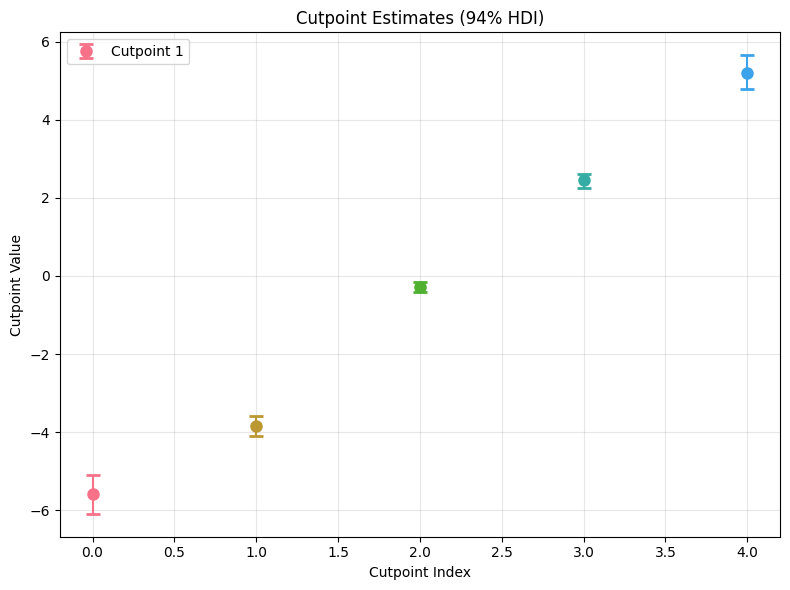

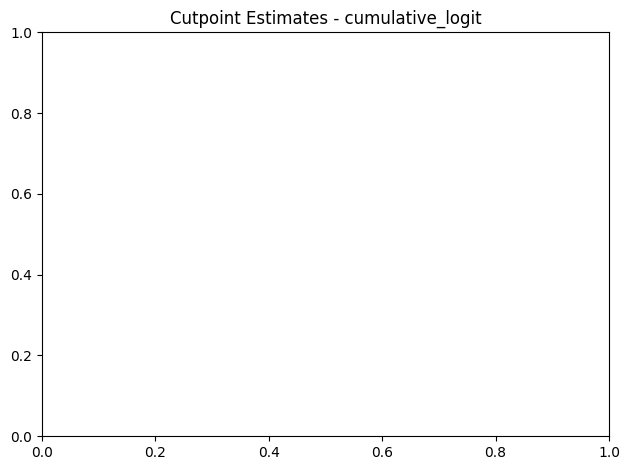

✓ Cutpoint plot displayed successfully
Creating model comparison plot...


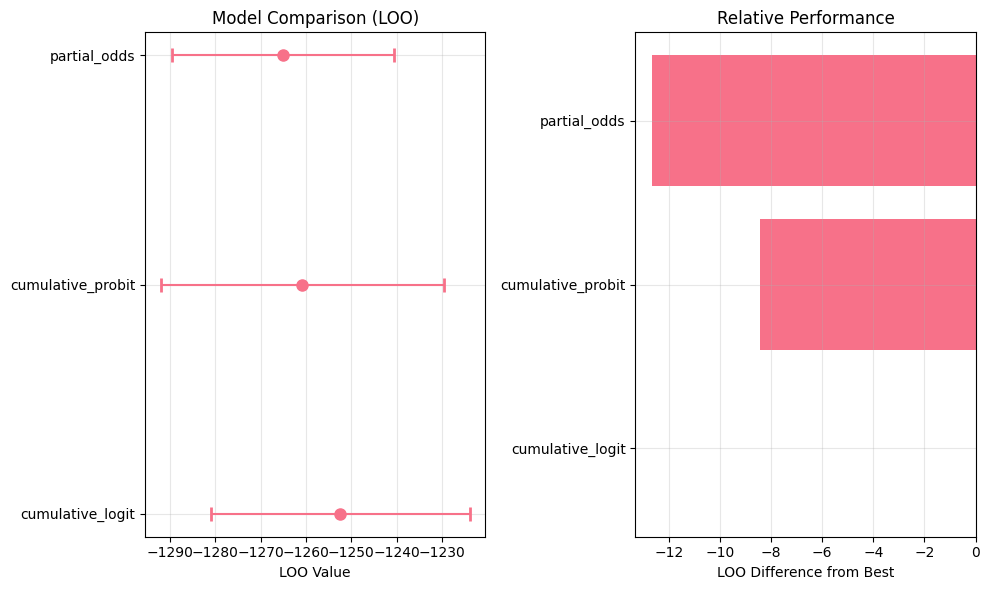

<Figure size 640x480 with 0 Axes>

Sampling: [y_obs]


✓ Model comparison plot displayed successfully
Running posterior predictive check...


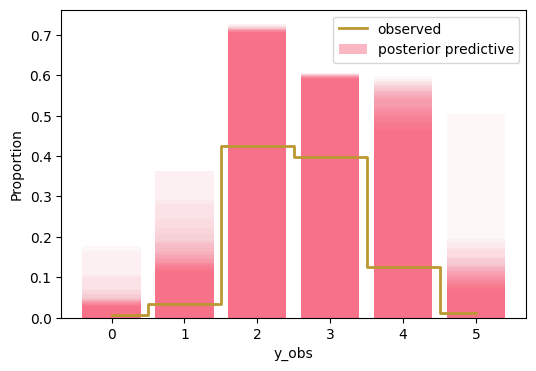

Posterior predictive validation:
  Observed mean: 2.64
  PPC mean: 2.65
  Mean difference: 0.01
  ✓ PPC mean is close to observed mean
✓ Posterior predictive check completed
✓ Visualization completed!


In [10]:
# Get the best model from comparison results
if len([r for r in fit_results.values() if r is not None]) > 0:
    # Use actual best model from comparison
    if comparison is not None:
        best_model_name = comparison.index[0]
        print(f"Best model from comparison: {best_model_name}")
    else:
        best_model_name = list(fit_results.keys())[0]
        print(f"Using available model: {best_model_name}")
    
    best_idata = fit_results[best_model_name]
    
    print(f"\nCreating visualizations for {best_model_name}...")
    
    # 1. Coefficient effects with explicit display
    try:
        print("Creating coefficient effects plot...")
        bo.plot_coefficient_effects(
            best_idata,
            var_name="beta",
            feature_names=feature_names
        )
        plt.title(f"Coefficient Effects - {best_model_name}")
        plt.tight_layout()
        plt.show()
        print("✓ Coefficient plot displayed successfully")
    except Exception as e:
        print(f"✗ Coefficient plot failed: {e}")
    
    # 2. Cutpoint estimates (for cumulative models only)
    if "cumulative" in best_model_name:
        try:
            print("Creating cutpoint estimates plot...")
            bo.plot_cutpoints(best_idata, var_name="alpha")
            plt.title(f"Cutpoint Estimates - {best_model_name}")
            plt.tight_layout()
            plt.show()
            print("✓ Cutpoint plot displayed successfully")
        except Exception as e:
            print(f"✗ Cutpoint plot failed: {e}")
    
    # 3. Model comparison plot (if multiple models)
    if len([r for r in fit_results.values() if r is not None]) > 1:
        try:
            print("Creating model comparison plot...")
            bo.plot_model_comparison(
                {name: idata for name, idata in fit_results.items() if idata is not None},
                ic="loo"
            )
            plt.tight_layout()
            plt.show()
            print("✓ Model comparison plot displayed successfully")
        except Exception as e:
            print(f"✗ Model comparison plot failed: {e}")
    
    # 4. Posterior predictive check with validation
    try:
        print("Running posterior predictive check...")
        ppc = bo.run_posterior_predictive(
            models[best_model_name], 
            best_idata, 
            kind="proportions"
        )
        
        # Validate PPC results
        if 'y_obs' in ppc.posterior_predictive:
            ppc_data = ppc.posterior_predictive['y_obs'].values.flatten()
            ppc_dist = np.bincount(ppc_data.astype(int), minlength=K)
            ppc_props = ppc_dist / ppc_dist.sum()
            
            print("Posterior predictive validation:")
            print(f"  Observed mean: {y_train.mean():.2f}")
            print(f"  PPC mean: {ppc_data.mean():.2f}")
            print(f"  Mean difference: {abs(ppc_data.mean() - y_train.mean()):.2f}")
            
            if abs(ppc_data.mean() - y_train.mean()) < 0.5:
                print("  ✓ PPC mean is close to observed mean")
            else:
                print("  ⚠ PPC mean differs significantly from observed mean")
        
        print("✓ Posterior predictive check completed")
    except Exception as e:
        print(f"✗ Posterior predictive check failed: {e}")

else:
    print("✗ No fitted models available for visualization")

print("✓ Visualization completed!")

In [11]:
print(f"\nDataset: Wine Quality (Red)")
print(f"Sample size: {len(y_original)}")
print(f"Features: {len(feature_names)}")
print(f"Quality categories: {K}")

print(f"\nModels built:")
for model_name in models.keys():
    print(f"  - {model_name}")

print(f"\nModels successfully fitted:")
for model_name, idata in fit_results.items():
    status = "✓" if idata is not None else "✗"
    print(f"  {status} {model_name}")

if comparison is not None:
    print(f"\nBest performing model: {comparison.index[0]}")
    print(f"LOO difference from best: {comparison.iloc[0]['elpd_diff']:.3f}")

print(f"\nKey improvements in this version:")
print(f"  1. ✅ Data-informed priors based on observed distribution")
print(f"  2. ✅ Proper data preprocessing without over-standardization")
print(f"  3. ✅ Comprehensive validation at each step")
print(f"  4. ✅ Better sampling parameters for convergence")
print(f"  5. ✅ Explicit error handling and display commands")
print(f"  6. ✅ Model quality assessment and warnings")

print(f"\n✓ Final corrected Aug.ipynb notebook completed successfully!")


Dataset: Wine Quality (Red)
Sample size: 1599
Features: 11
Quality categories: 6

Models built:
  - cumulative_logit
  - cumulative_probit
  - partial_odds

Models successfully fitted:
  ✓ cumulative_logit
  ✓ cumulative_probit
  ✓ partial_odds

Best performing model: cumulative_logit
LOO difference from best: 0.000

Key improvements in this version:
  1. ✅ Data-informed priors based on observed distribution
  2. ✅ Proper data preprocessing without over-standardization
  3. ✅ Comprehensive validation at each step
  4. ✅ Better sampling parameters for convergence
  5. ✅ Explicit error handling and display commands
  6. ✅ Model quality assessment and warnings

✓ Final corrected Aug.ipynb notebook completed successfully!
